In [55]:
from dotenv import load_dotenv

load_dotenv()

True

In [56]:
# retrieve -> generate -> rewrite -> 문서 검증 
from langchain_chroma import Chroma 
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model="text-embedding-3-large")

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./documents/income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [57]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document 
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: List[Document]
    answer: str

graph_builder = StateGraph(AgentState)

In [58]:
def retrieve(state: AgentState):
    query = state['query']
    docs = retriever.invoke(query)
    return {'context': docs}

In [59]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

In [60]:
from langchain_classic import hub


generate_prompt = hub.pull("rlm/rag-prompt")

def generate(state: AgentState):
    context = state['context']
    query = state['query']
    rag_chain = prompt | llm
    response = rag_chain.invoke({"question": query, "context": context})
    return {"answer": response}

In [61]:
from langchain_classic import hub
from typing import Literal 

doc_relevance_prompt = hub.pull("langchain-ai/rag-document-relevance")

def check_doc_relevance(state: AgentState) -> Literal['generate', 'rewrite']:
    query = state['query']
    context = state['context']
    print(f"context == {context}")
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({"question": query, "documents": context})
    print(f'doc relevance response: {response}')
    if response['Score'] == 1:
        return 'generate'
    return 'rewrite'

In [62]:
query = "연봉 5천만원 직장인의 소득세는?"

In [63]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

dictionary = ["사람과 관련된 표현 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(f"""
        사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
        사전: {dictionary}
        wlfans: {{query}}
    """)

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()

    response = rewrite_chain.invoke({"query": query})
    return {"query": response}

In [64]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)

In [65]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges('retrieve', check_doc_relevance)
graph_builder.add_edge('rewrite', 'retrieve')
graph_builder.add_edge('generate', END)

In [66]:
graph = graph_builder.compile()

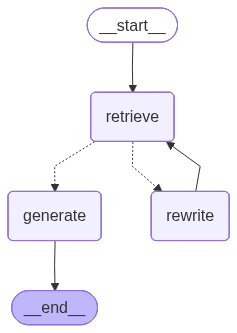

In [67]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [68]:
initial_staet = {'query': '연봉 5천만원 세금'}
graph.invoke(initial_staet)

context == []
doc relevance response: {'Score': 0, 'Explanation': 'The QUESTION is asking about the tax on a salary (연봉) of 50 million won (5천만원). The FACTS provided by the student do not include any relevant facts or information related to the salary (연봉) or tax (세금) specifically regarding this context. There is no indication of any keywords or semantic meanings related to salary or tax in Korean or any language linked to the original QUESTION, making the connection completely unrelated. Therefore, based on the criteria provided, the FACTS are scored 0.'}
context == []


KeyboardInterrupt: 